### Модели предсказания сепсиса

Ноутбук содержит анализ данных пациентов с сепсисом. Цель - разработка моделей, способных предсказывать наличие сепсиса по простым признакам, не требующим лабораторного исследования (САД, сатурация, ЧСС, Пол, Возраст, Наличие/отсутствие инфекции). Подобные модели позволят проводить быстрый скрининг наличия сепсиса у паиентов без применения лабораторных методов исследования.

Данные взяты из открытых источников:

Данные: https://zenodo.org/record/3550014

Статья: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0225700



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
     classification_report, 
    confusion_matrix
)

RAND=77
#
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")
#
from sklearn.model_selection import RandomizedSearchCV
#
import torch
import random
#
random.seed(RAND)
np.random.seed(RAND)
torch.manual_seed(RAND)

In [2]:
def get_union(a, b):
    return 1 if a and b else 0

### Загрузка первичных данных

Отбор признаков интереса: САД, сатурация, ЧСС, Пол, Возраст, Наличие/отсутствие инфекции

Наличие сепсиса определяется по стандарту Сепсис-3 как наличие подтвержденной инфекции и баллы по шкале SOFA > 2

In [3]:
D = pd.read_excel('Dataset.xlsx')
drop_cols = D.columns.values[D.isna().sum().values>(D.shape[0]*0.1)]
D = D.drop(drop_cols, axis=1)
D = D[['F6A SBP in ED','F6D Sat% in ED', 'F6G HR/min in ED',
    'Gender', 'Age (yrs)', 'Infection', 'SOFA points']] # САД, сатурация, ЧСС, Пол, Возраст, Наличие/отсутствие инфекции
#
D['Sepsis'] = list(map(lambda x: get_union(D.iloc[x].Infection == 'Yes',
                             D.iloc[x]['SOFA points'] >= 2), D.index.values)) # Определяем сепсис
#
D = D.drop(['SOFA points'], axis=1)
print(D.shape)
D.head(3)

(2196, 7)


,F6A SBP in ED,F6D Sat% in ED,F6G HR/min in ED,Gender,Age (yrs),Infection,Sepsis
0,155.0,96.0,60.0,Male,81,Yes,0
1,159.0,100.0,79.0,Male,61,Yes,0
2,134.0,97.0,66.0,Male,77,Yes,0


Уберем пропущенные значения и трансформируем бинарные признаки

In [4]:
D = D.dropna()
D.shape

(1996, 7)

In [5]:
D.Gender = list(map(lambda x: 1 if x == 'Male' else 0, D.Gender))
#
for i in ['Infection']:
    D[i] = list(map(lambda x: 1 if x == 'Yes' else 0, D[i]))
D.head()

,F6A SBP in ED,F6D Sat% in ED,F6G HR/min in ED,Gender,Age (yrs),Infection,Sepsis
0,155.0,96.0,60.0,1,81,1,0
1,159.0,100.0,79.0,1,61,1,0
2,134.0,97.0,66.0,1,77,1,0
3,94.0,96.0,97.0,1,19,0,0
4,110.0,94.0,100.0,1,84,1,0


Всего в полученном датасете содержится информация о 1996 пациентах

**Тренировка и валидация**

In [6]:
X = D.drop('Sepsis', axis=1)
y = D.Sepsis
#
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, random_state=RAND, train_size=0.6)
print("Train|test size", X_train.shape, X_test.shape)
#
train_index = X_train.index # ИНДЕКС ТРЕНИРОВКИ
#
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,stratify=y_test, random_state=RAND, train_size=0.6)
print("Train|test size", X_test.shape, X_val.shape)
#
test_index = X_test.index # ИНДЕКСЫ ТЕСТА
val_index = X_val.index # ИНДЕКСЫ ВАЛИДАЦИИ
print("Train|test|validation size", X_train.shape, X_test.shape, X_val.shape)

Train|test size (1197, 6) (799, 6)
Train|test size (479, 6) (320, 6)
Train|test|validation size (1197, 6) (479, 6) (320, 6)


Получено 3 набора данных: тренировка, тест и валидация

In [7]:
cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=RAND)

Проводим нормализацию признаков

In [7]:
num_fech = ['F6A SBP in ED', 'F6D Sat% in ED', 'F6G HR/min in ED','Age (yrs)']
sc = StandardScaler()
train_num = sc.fit_transform(X_train[num_fech])
print(sc.mean_) # Mean
print(np.sqrt(sc.var_)) # STD

[134.01169591  93.63909774  96.49373434  68.93400167]
[26.43855815  5.23388566 20.60884471 18.6211804 ]


Сохраним значения для дальнейшего использования

In [8]:
#['F6A SBP in ED', 'F6D Sat% in ED', 'F6G HR/min in ED','Age (yrs)']
sc_mean = np.array([134.01169591,  93.63909774,  96.49373434,  68.93400167])
sc_std = np.array([26.43855815,  5.23388566, 20.60884471, 18.6211804])

In [9]:
for x in [X_train, X_test, X_val]:
    x['F6A SBP in ED'] = (x['F6A SBP in ED']-134.01169591)/26.43855815
    x['F6D Sat% in ED'] = (x['F6D Sat% in ED']-93.63909774)/5.23388566
    x['F6G HR/min in ED'] = (x['F6G HR/min in ED']-96.49373434)/20.60884471
    x['Age (yrs)'] = (x['Age (yrs)']-68.93400167)/18.6211804
    x = x[['F6A SBP in ED', 'F6D Sat% in ED', 'F6G HR/min in ED', 'Age (yrs)',
       'Gender', 'Infection']]
X_train.head(2)

,F6A SBP in ED,F6D Sat% in ED,F6G HR/min in ED,Gender,Age (yrs),Infection
1709,-0.038266,0.451080,0.558317,0,-0.103860,1
2137,-0.189560,0.260018,0.849454,1,0.862781,1


**Модели**

Логистическая регрессия

In [10]:
lr_best_params = {'C': 1.0, 'l1_ratio': 0.25, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'}
lr_gr = LogisticRegression(**lr_best_params, class_weight="balanced", random_state=RAND)
#
lr_gr.fit(X_train, y_train)
y_pred = lr_gr.predict(X_test)
y_pred_roc = lr_gr.predict_proba(X_test)[:,1]
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC_AUC:", roc_auc_score(y_test, y_pred_roc))

Accuracy 0.7348643006263048
Precision: 0.803088803088803
Recall: 0.7323943661971831
F1: 0.7661141804788213
ROC_AUC: 0.8343986998916576


Случайный лес

In [11]:
random_forest_best_params = {'max_depth': None, 'max_features': 3, 'n_estimators': 600}
random_forest_gr = RandomForestClassifier(**random_forest_best_params, class_weight='balanced', random_state=RAND)
#
random_forest_gr.fit(X_train, y_train)
y_pred = random_forest_gr.predict(X_test)
y_pred_roc = random_forest_gr.predict_proba(X_test)[:,1]
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC_AUC:", roc_auc_score(y_test, y_pred_roc))

Accuracy 0.7181628392484343
Precision: 0.7508417508417509
Recall: 0.7852112676056338
F1: 0.7676419965576592
ROC_AUC: 0.8203683640303359


XGBoost

In [12]:
import joblib
xgb = joblib.load('xgb_1.pkl')

In [13]:
param = {'gamma': 7, 'max_depth': 10, 'n_estimators': 500, 
         'alpha': 1, 'colsample_bytree': 1, 'num_leaves': 10}
xgb = xgboost.XGBClassifier(**param, class_weight='balanced', random_state=RAND)
xgb.fit(X_train, y_train)
#
y_pred = xgb.predict(X_test)
y_pred_roc = xgb.predict_proba(X_test)[:,1]
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC_AUC:", roc_auc_score(y_test, y_pred_roc))

[19:30:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:30:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy 0.7724425887265136
Precision: 0.7692307692307693
Recall: 0.8802816901408451
F1: 0.8210180623973728
ROC_AUC: 0.8450975081256771


Полносвязные нейронные сети

In [14]:
X_train_n = torch.FloatTensor(X_train.values)
X_test_n = torch.FloatTensor(X_test.values)
y_train_n = torch.LongTensor(y_train.values)
y_test_n = torch.LongTensor(y_test.values)
#
X_val_n = torch.FloatTensor(X_val.values)
y_val_n = torch.LongTensor(y_val.values)

In [15]:
class STNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(STNet, self).__init__()

        self.fc1 = torch.nn.Linear(6, n_hidden_neurons)
        self.activ1 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons*2)
        self.activ2 = torch.nn.Tanh()
        self.fc3 = torch.nn.Linear(n_hidden_neurons*2, 2)
        #
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

In [16]:
snet_2 = STNet(2)
loss = torch.nn.CrossEntropyLoss()
optimizer_2 = torch.optim.Adam(snet_2.parameters(),
                             lr=3.0e-4)
#
batch_size = 300
#
for epoch in range(1500):
    order = np.random.permutation(len(X_train_n))
    for start_index in range(0, len(X_train_n), batch_size):
        optimizer_2.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train_n[batch_indexes]
        y_batch = y_train_n[batch_indexes]
        
        preds = snet_2.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer_2.step()

In [71]:
test_preds = snet_2.forward(X_test_n)
test_preds_prob = snet_2.sm(test_preds)[:,1]
test_preds = test_preds.argmax(dim=1)
#
print("Accuracy", accuracy_score(y_test_n, test_preds))
print("Precision:", precision_score(y_test_n, test_preds))
print("Recall:", recall_score(y_test_n, test_preds))
print("F1:", f1_score(y_test_n, test_preds))
print("ROC_AUC:", roc_auc_score(y_test_n.numpy(), test_preds_prob.detach().numpy()))

Accuracy 0.7578288100208769
Precision: 0.7763157894736842
Recall: 0.8309859154929577
F1: 0.802721088435374
ROC_AUC: 0.8328819068255687


In [73]:
# torch.save(snet_2, 'SNet_Prime.pth') # СОХРАНИТЬ МОДЕЛЬ

In [17]:
model = torch.load('SNet_Prime.pth')
test_preds = model.forward(X_test_n)
test_preds_prob = model.sm(test_preds)[:,1]
test_preds = test_preds.argmax(dim=1)
#
print("Accuracy", accuracy_score(y_test_n, test_preds))
print("Precision:", precision_score(y_test_n, test_preds))
print("Recall:", recall_score(y_test_n, test_preds))
print("F1:", f1_score(y_test_n, test_preds))
print("ROC_AUC:", roc_auc_score(y_test_n.numpy(), test_preds_prob.detach().numpy()))

Accuracy 0.7578288100208769
Precision: 0.7763157894736842
Recall: 0.8309859154929577
F1: 0.802721088435374
ROC_AUC: 0.8328819068255687


**Валидируем**

In [18]:
metrics_val = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'])
models = [lr_gr, random_forest_gr, xgb]
names = ["LogReg", "RandForest", "XGBoost"]
for i in range(len(models)):
#     models[i].fit(X_train_1, y_train)
    #
    y_pred = models[i].predict(X_val)
    y_pred_roc = models[i].predict_proba(X_val)[:,1]
    #
    metrics_val[names[i]] = [accuracy_score(y_val, y_pred),
    precision_score(y_val, y_pred),
    recall_score(y_val, y_pred),
    f1_score(y_val, y_pred),
    roc_auc_score(y_val, y_pred_roc)]
#
test_preds = model.forward(X_val_n)
test_preds_prob = model.sm(test_preds)[:,1]
test_preds = test_preds.argmax(dim=1)
metrics_val['NN'] = [accuracy_score(y_val_n, test_preds),
    precision_score(y_val_n, test_preds),
    recall_score(y_val_n, test_preds),
    f1_score(y_val_n, test_preds),
    roc_auc_score(y_val_n.numpy(), test_preds_prob.detach().numpy())]
metrics_val.T

,accuracy,precision,recall,f1,roc-auc
LogReg,0.778125,0.827778,0.788360,0.807588,0.855770
RandForest,0.734375,0.754902,0.814815,0.783715,0.830910
XGBoost,0.771875,0.771028,0.873016,0.818859,0.856113
NN,0.765625,0.785000,0.830688,0.807198,0.860172


___

Для проверки исползуем другой набор открытых данных (от авторов статьи оригинального набора)

https://gupea.ub.gu.se/handle/2077/53613

In [25]:
check = r'C:\Users\pfft\OneDrive\Рабочий стол\POSTDOC\Проекты\Сепсис\SWEEDEN_sepsis_biomark\Sepsis_biomarker_study_2011-2012_Sweden.xlsx'
data = pd.read_excel(check)
data = data.replace([' '], np.nan)
df = data.dropna()
print(df.shape)
#
df = df.replace(['No', 'Yes'], [0, 1])
df = df.replace(['Male', 'Female'], [0, 1])
df.head(3)

(1194, 23)


,ID,Age,Gender,SAD,Respiratory_rate,Saturation,Heart_rate,Temperature,Haemoglobin,Leukocytes,...,Lactate,Intensive_care_unit,survival_28,Blood_culture,Proven_infection,SIRS,SOFA_2,Sepsis_2,Septic_shock,Sepsis_3
0,1,79,1,136.0,16.0,99.0,77.0,37.4,98.0,10.3,...,1.52,0,1,0,1,0,0,0,0,0
2,3,54,0,148.0,18.0,97.0,107.0,38.5,139.0,9.5,...,1.28,0,1,0,1,1,0,1,0,0
3,4,52,0,138.0,16.0,96.0,120.0,37.0,153.0,10.8,...,2.46,0,1,0,0,0,0,0,0,0


В данных содержится информация об 1194 пациентах

Проводим нормализацию по старым данным

In [26]:
X = df[['SAD', 'Saturation', 'Heart_rate ', 'Gender', 'Age',
       'Proven_infection']]
y = df['Sepsis_3']
#
#
X['SAD'] = (X['SAD']-134.01169591)/26.43855815
X['Saturation'] = (X['Saturation']-93.63909774)/5.23388566
X['Heart_rate '] = (X['Heart_rate ']-96.49373434)/20.60884471
X['Age'] = (X['Age']-68.93400167)/18.6211804
#
X.columns = ['F6A SBP in ED', 'F6D Sat% in ED', 'F6G HR/min in ED', 'Gender','Age (yrs)', 'Infection']
print(X.shape)
X.head()

(1194, 6)


,F6A SBP in ED,F6D Sat% in ED,F6G HR/min in ED,Gender,Age (yrs),Infection
0,0.075205,1.024268,-0.945892,1,0.540567,1
2,0.529087,0.642143,0.509794,0,-0.801990,1
3,0.150852,0.451080,1.140591,0,-0.909395,0
5,-0.492148,1.215331,-0.121003,0,-0.640883,1
6,-0.643443,0.260018,-0.945892,1,0.379460,1


In [27]:
X_n = torch.FloatTensor(X.values)
y_n = torch.LongTensor(y.values)

**Валидация на другом наборе данных**

In [29]:
metrics_t = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'])
models = [lr_gr, random_forest_gr, xgb]
names = ["LogReg", "RandForest", "XGBoost"]
for i in range(len(models)):
#     models[i].fit(X_train_1, y_train)
    #
    y_pred = models[i].predict(X)
    y_pred_roc = models[i].predict_proba(X)[:,1]
    #
    metrics_t[names[i]] = [accuracy_score(y, y_pred),
    precision_score(y, y_pred),
    recall_score(y, y_pred),
    f1_score(y, y_pred),
    roc_auc_score(y, y_pred_roc)]
#
test_preds = model.forward(X_n)
test_preds_prob = model.sm(test_preds)[:,1]
test_preds = test_preds.argmax(dim=1)
metrics_t['NN'] = [accuracy_score(y_n, test_preds),
    precision_score(y_n, test_preds),
    recall_score(y_n, test_preds),
    f1_score(y_n, test_preds),
    roc_auc_score(y_n.numpy(), test_preds_prob.detach().numpy())]
metrics_t.T

,accuracy,precision,recall,f1,roc-auc
LogReg,0.832496,0.796954,0.723502,0.758454,0.924730
RandForest,0.889447,0.849537,0.845622,0.847575,0.958624
XGBoost,0.860972,0.775720,0.868664,0.819565,0.941038
NN,0.840871,0.760684,0.820276,0.789357,0.927898


**На обоих валидационных датасетах XGBoost в среднем показывает наилучшее качество**

___

### Исследуем значимость признаков с помощью SHAP

In [33]:
import shap
#
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
def get_shap_plot(model, X_train):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
#     shap.summary_plot(shap_values, X_train, plot_type='bar')
    shap.summary_plot(shap_values[1], X_train)

Значимость на тренировочных наборах

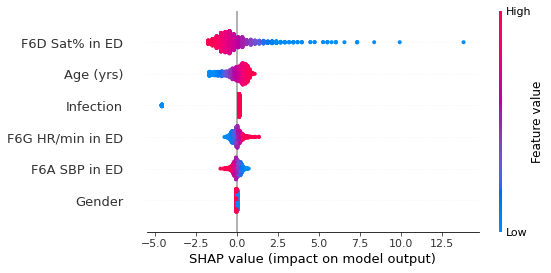

In [35]:
explainer = shap.LinearExplainer(lr_gr, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

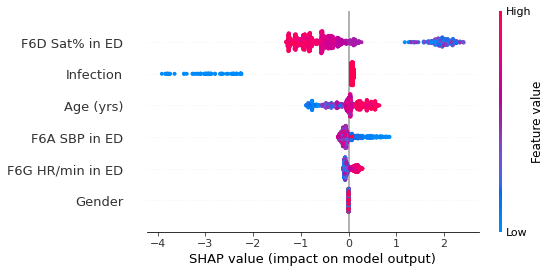

In [36]:
explainer = shap.TreeExplainer(xgb, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

___

Значимость на валидационных наборах

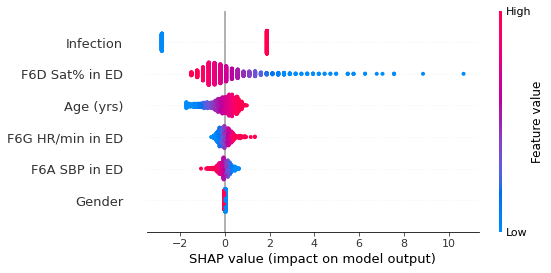

In [38]:
explainer = shap.LinearExplainer(lr_gr, X)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

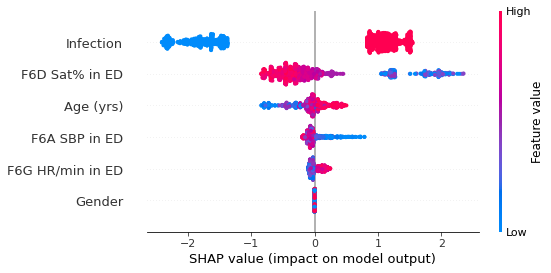

In [39]:
explainer = shap.TreeExplainer(xgb, X)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)